In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm #Used to display images in a specific colormap
from scipy.io import loadmat
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 7.0)
np.set_printoptions(suppress=True) # Don't print scietific numbers form

# 1 Neural Networks

In [2]:
data = loadmat('ex4/ex4data1.mat')
data.keys()

dict_keys(['y', 'X', '__globals__', '__header__', '__version__'])

In [3]:
X = np.c_[np.ones( data['X'].shape[0] ), data['X']]
y = data['y']

m = X.shape[0] # number of training examples
n = X.shape[1] # number of features (with bias unit)

print( '(',m,', ',n, ')' )

( 5000 ,  401 )


1.1 Visualizing the data

(20, 200)


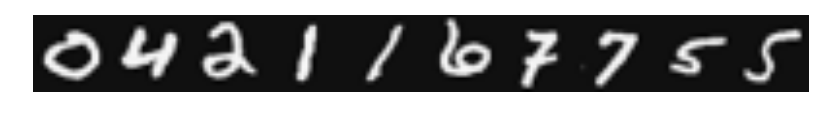

In [4]:
sample = np.random.randint( 0, X.shape[0] + 1, 10 )
data_plot = X[sample, 1: ].reshape( -1, 20 ).T # Make a 20X20 array and rotate
print(data_plot.shape)
img = plt.imshow(data_plot, cmap = cm.Greys_r)
plt.axis('off');

1.2 Model representation

In [5]:
weights_data = loadmat('ex4/ex4weights.mat')
weights_data.keys()

dict_keys(['Theta1', '__globals__', '__header__', 'Theta2', '__version__'])

In [6]:
theta1, theta2 = weights_data['Theta1'], weights_data['Theta2']
print( theta1.shape, theta2.shape)

(25, 401) (10, 26)


1.3 Feedforward and cost function

In [7]:
# minimize(fun, x0[, args, method, jac, hess, ...]) performs a minimization of scalar function of one or more variables.
from scipy.optimize import minimize
import pandas as pd

In [8]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x) )

In [9]:
def sigmoid_gradient(z):
    return sigmoid(z)*( 1 - sigmoid(z) )

In [10]:
def rand_initialize_weights(L_in, L_out):
    #eps = math.sqrt(6)/math.sqrt(L_in + L_out)
    eps = 0.12
    return 2 * eps * np.random.random_sample((L_out, L_in + 1)) - eps 

In [11]:
def nn_cost_function( nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmda ):
    # roll-back the parameters
    theta1 = nn_params[0:( hidden_layer_size * (input_layer_size + 1) )].reshape( hidden_layer_size, (input_layer_size + 1) )
    theta2 = nn_params[( hidden_layer_size * (input_layer_size + 1) ):].reshape( num_labels, (hidden_layer_size + 1) )

    m = X.shape[0]
    a1 = X
    
    z2 = theta1.dot( a1.T )
    a2 = np.r_[ np.ones( (1, z2.shape[1]) ), sigmoid(z2) ]
    
    z3 = theta2.dot( a2 )
    a3 = sigmoid(z3) # 10x5000
    
    # convert the labels to a 10-d vector
    Y = pd.get_dummies( y.ravel() ).as_matrix() # 5000x10
    
    # the summation in the lectures is equivalent to taking the trace of the multiplication (10x10) matrix 
    J = (-1/m) * np.trace( np.log(a3).dot( Y ) + np.log( 1 - a3 ).dot( ( 1 - Y ) ) ) + \
            ( lmda/(2*m) ) * ( np.trace( (theta1[:,1:]).T.dot(theta1[:,1:]) ) + np.trace( (theta2[:,1:]).T.dot(theta2[:,1:]) ) ) # no regularization on the bias units

    # 2. Backpropagation

    delta3 = a3.T - Y # error of the output layer (5000x10)
    delta2 = theta2[:, 1:].T.dot(delta3.T) * sigmoid_gradient(z2) # (25x10) x (10x5000) * (25x5000) = (25x5000)

    D1 = delta2.dot(a1) # (25x5000) x (5000x401) = (25x401)
    D2 = delta3.T.dot(a2.T) # (10x5000) x (5000x26) = (10x26)

    theta1_reg = np.c_[np.ones((theta1.shape[0],1)),theta1[:,1:]]
    theta2_reg = np.c_[np.ones((theta2.shape[0],1)),theta2[:,1:]]
    
    theta1_grad = D1/m + (theta1_reg * lmda)/m 
    theta2_grad= D2/m + (theta2_reg * lmda)/m
    
    grad = np.r_[theta1_grad.ravel(), theta2_grad.ravel()]
    
    return (J, grad)

In [12]:
nn_params = np.r_[theta1.ravel(), theta2.ravel()]
print( 'unregularized cost (lambda = 0) = ', nn_cost_function(nn_params, theta1.shape[1]-1, theta1.shape[0], theta2.shape[0], X, y, 0)[0] )

unregularized cost (lambda = 0) =  0.287629165161


In [13]:
print( 'regularized cost (lambda = 1) = ', nn_cost_function(nn_params, theta1.shape[1]-1, theta1.shape[0], theta2.shape[0], X, y, 1)[0] )

regularized cost (lambda = 1) =  0.383769859091


# 2 Backpropagation

In [14]:
sigmoid_gradient(np.array(([0, -10,100],[0,10,100])))

array([[ 0.25     ,  0.0000454,  0.       ],
       [ 0.25     ,  0.0000454,  0.       ]])

In [15]:
print (rand_initialize_weights(2,3))

[[ 0.01591477  0.06130089 -0.09759144]
 [-0.08224116  0.07206596 -0.09992965]
 [-0.06457825 -0.02883665  0.09413022]]


In [16]:
def compute_numerical_gradient(theta, lmda):
    eps = 10**(-4)
    numgrad = np.zeros(theta.size)
    perturb = np.zeros(theta.size)
    for i in range (0, theta.size):
        perturb[i] = eps
        J_plus = nn_cost_function(theta + perturb, theta1.shape[1]-1, theta1.shape[0], theta2.shape[0], X, y, lmda)[0]
        J_minus = nn_cost_function(theta - perturb, theta1.shape[1]-1, theta1.shape[0], theta2.shape[0], X, y, lmda)[0]
        numgrad[i] = ( J_plus - J_minus )/(2*eps)
        perturb[i] = 0
    return numgrad

In [17]:
def check_nn_gradients(nn_params, lmda):
    numgrad = compute_numerical_gradient(nn_params, lmda)
    cost, grad = nn_cost_function(nn_params, theta1.shape[1]-1, theta1.shape[0], theta2.shape[0], X, y, 0)
    return np.linalg.norm( numgrad - grad )/np.linalg.norm( numgrad + grad )

In [18]:
#check_nn_gradients(nn_params, 0)

In [19]:
theta1_0 = rand_initialize_weights(400, 25)
theta2_0 = rand_initialize_weights(25, 10)
theta_0 = np.r_[theta1_0.ravel(), theta2_0.ravel()]

In [64]:
lmda = 1
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
nn = minimize( fun = nn_cost_function, x0 = theta_0, 
              args = (input_layer_size, hidden_layer_size, num_labels, X, y, lmda), 
              method = 'CG', jac = True, options = {'maxiter' : 400} )

In [65]:
nn

     fun: 0.3154233412978958
     jac: array([ 0.00011996, -0.        ,  0.        , ..., -0.0000012 ,
       -0.00000731, -0.00001873])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1228
     nit: 400
    njev: 1227
  status: 1
 success: False
       x: array([-2.98391341, -0.00000202,  0.00000817, ...,  1.92843455,
        2.76943595, -2.12982482])

In [66]:
res_layer1 = nn.x[0:( hidden_layer_size * (input_layer_size + 1) )].reshape( hidden_layer_size, (input_layer_size + 1) )
res_layer2 = nn.x[( hidden_layer_size * (input_layer_size + 1) ):].reshape( num_labels, (hidden_layer_size + 1) )
print(res_layer1.shape)

(25, 401)


In [67]:
# A function that returns the prediction ( i.e. the written number ) for each data point
def predict_one_vs_all( all_thetas, X ):
    probability = sigmoid( X.dot(all_thetas.T) )
    return ( np.argmax( probability, axis = 1 ) + 1 ) # argmax returns the index of the maximum entry along an axis

In [68]:
def predict( theta1, theta2, X ):
    z2 = theta1.dot( X.T )
    a2 = np.r_[ np.ones( (1, z2.shape[1]) ), sigmoid(z2) ].T
    a3 = predict_one_vs_all( theta2, a2 )
    return a3

In [69]:
training_accuracy = np.mean( ( y.ravel() == predict( res_layer1, res_layer2, X ))*100 )
print( 'training accuracy = ', training_accuracy )

training accuracy =  99.6


# 3 Visualizing the hidden layer

In [72]:
def display_hidden_layer(layer1):
    #remove bias unit:
    layer = theta1[5:10,1:]
    HL_plot = layer.reshape( -1, 20 ).T # Make a 20X20 array and rotate
    img = plt.imshow(HL_plot)#, cmap = cm.Greys_r)
    plt.axis('off');

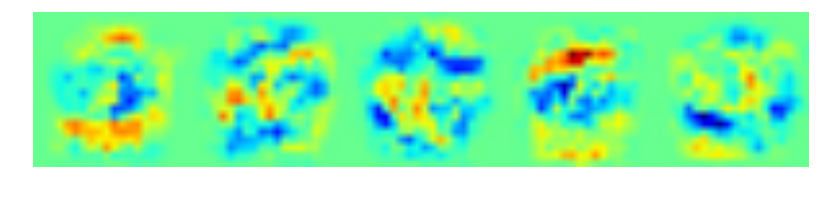

In [73]:
display_hidden_layer(res_layer1)